## **Task**
The task in this assingment was to classification analysis on the IMDB dataset by training and comparing single-layer and two-layer multilayer perceptron (MLP) models using SentencePiece tokenization. It evaluates model performance through accuracy metrics, visualizations, and error analysis.

### **Hyperparameters**
```
batch_size = 64
EPOCHS = 10
Learning rate = 0.001
Embedding Dimension = 64
Number of Classes = 2
Dropout Rate = 0.3
```

In [16]:
# Install necessary packages if not already installed
!pip install sentencepiece torch==2.3.0 torchtext==0.18.0 torchdata portalocker>=2.0.0 datasets matplotlib scikit-learn

# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset
import random
import sentencepiece as spm

Using device: cuda
SentencePiece model already exists. Skipping training.


True

In [ ]:
# Set seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed(0)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Load IMDB dataset
imdb_dataset = load_dataset('imdb')

# Split into train and test
train_data = imdb_dataset['train']
test_data = imdb_dataset['test']

A tokenizer is a tool that splits text into smaller units called tokens. These tokens can be words, subwords, or characters, depending on the tokenizer's design. <br />
Why training the tokenizer? The IMDB dataset contains movie reviews with specific vocabulary, slang, and expressions. A tokenizer trained on this dataset can better capture the unique linguistic patterns present, leading to more effective feature representation.

In [ ]:
# Train SentencePiece model if not already trained
import os

if not os.path.exists('spm.model'):
    # Combine all training texts into a single file for training SentencePiece
    with open('train_text.txt', 'w', encoding='utf-8') as f:
        for sample in train_data:
            f.write(sample['text'] + '\n')

    # Train the SentencePiece model
    spm.SentencePieceTrainer.train(
        input='train_text.txt',
        model_prefix='spm',
        vocab_size=8000,
        model_type='unigram',
        character_coverage=1.0,
        pad_id=0,
        unk_id=1,
        bos_id=-1,
        eos_id=-1
    )
else:
    print("SentencePiece model already exists. Skipping training.")

# Initialize SentencePieceProcessor and load the model
sp = spm.SentencePieceProcessor()
sp.load('spm.model')  # Ensure the model path is correct

In [17]:
# Define the text pipeline using SentencePiece
def text_pipeline(x):
    return sp.encode(x, out_type=int)  # Encodes text to token IDs

# Define the label pipeline
label_pipeline = lambda x: x  # Labels are already 0 (neg) and 1 (pos)

# Function to collate batches
def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for sample in batch:
        label = label_pipeline(sample['label'])
        label_list.append(label)
        processed_text = torch.tensor(text_pipeline(sample['text']), dtype=torch.int64)
        text_list.append(processed_text)
        offsets.append(processed_text.size(0))
    label_tensor = torch.tensor(label_list, dtype=torch.int64)
    text_tensor = torch.cat(text_list)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    return text_tensor.to(device), offsets.to(device), label_tensor.to(device)

# Hyperparameters
batch_size = 64
EPOCHS = 10
LR = 0.001  # Learning rate for Adam
EMBED_DIM = 64
HIDDEN_DIM_100 = 100
HIDDEN_DIM_200 = 200
NUM_CLASS = 2
DROPOUT = 0.3  # Increased dropout to reduce overfitting
vocab_size = sp.get_piece_size()  # Get the vocabulary size from SentencePiece

# Define DataLoaders
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

In [18]:
# Define the Two-Layer MLP
class TwoLayerMLP(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class, hidden_dim, dropout):
        super(TwoLayerMLP, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=False)
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_class)
        self.dropout = nn.Dropout(dropout)
        self.init_weights()

    def init_weights(self):
        torch.nn.init.xavier_uniform_(self.embedding.weight)
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        self.fc1.bias.data.zero_()
        torch.nn.init.xavier_uniform_(self.fc2.weight)
        self.fc2.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        out = self.fc1(embedded)
        out = F.relu(out)
        out = self.dropout(out)
        return self.fc2(out)

In [19]:
# Define the Single-Layer MLP (with corrections)
class SingleLayerMLP(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class, dropout):
        super(SingleLayerMLP, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=False)  # Changed sparse=False
        self.fc = nn.Linear(embed_dim, num_class)
        self.dropout = nn.Dropout(dropout)
        self.init_weights()

    def init_weights(self):
        torch.nn.init.xavier_uniform_(self.embedding.weight)
        torch.nn.init.xavier_uniform_(self.fc.weight)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        embedded = self.dropout(embedded)  # Apply dropout after embedding
        return self.fc(embedded)

In [20]:
# Define different model configurations
model_configs = {
    'TwoLayer_100': {'type': 'TwoLayer', 'hidden_dim': HIDDEN_DIM_100},
    'TwoLayer_200': {'type': 'TwoLayer', 'hidden_dim': HIDDEN_DIM_200},
    'SingleLayer': {'type': 'SingleLayer'}
}

# Initialize models, optimizers, and criteria
models = {}
optimizers = {}
criteria = {}
train_accuracies = {}
test_accuracies = {}

for name, config in model_configs.items():
    if config['type'] == 'TwoLayer':
        model = TwoLayerMLP(vocab_size, EMBED_DIM, NUM_CLASS, hidden_dim=config['hidden_dim'], dropout=DROPOUT).to(device)
    elif config['type'] == 'SingleLayer':
        model = SingleLayerMLP(vocab_size, EMBED_DIM, NUM_CLASS, dropout=DROPOUT).to(device)
    models[name] = model
    # Assign Adam optimizer for all models
    optimizers[name] = torch.optim.Adam(model.parameters(), lr=LR)
    # Assign loss function
    criteria[name] = nn.CrossEntropyLoss()
    # Initialize accuracy lists
    train_accuracies[name] = []
    test_accuracies[name] = []

In [21]:
# Training and evaluation functions
def train_model(model, dataloader, optimizer, criterion):
    model.train()
    total_acc, total_count = 0, 0
    total_loss = 0
    for text, offsets, labels in dataloader:
        optimizer.zero_grad()
        output = model(text, offsets)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        total_acc += (output.argmax(1) == labels).sum().item()
        total_count += labels.size(0)
        total_loss += loss.item() * labels.size(0)
    return total_acc / total_count, total_loss / total_count

def evaluate_model(model, dataloader, criterion):
    model.eval()
    total_acc, total_count = 0, 0
    total_loss = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for text, offsets, labels in dataloader:
            output = model(text, offsets)
            loss = criterion(output, labels)
            preds = output.argmax(1)
            total_acc += (preds == labels).sum().item()
            total_count += labels.size(0)
            total_loss += loss.item() * labels.size(0)
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())
    return total_acc / total_count, total_loss / total_count, all_preds, all_labels

In [22]:
# Function to reconstruct text from tokens using SentencePiece
def text_pipeline_reverse(spm_model, text, offsets, index):
    start = offsets[index]
    end = offsets[index + 1] if index + 1 < len(offsets) else text.size(0)
    tokens = text[start:end].tolist()
    return spm_model.decode(tokens)

# Get misclassified samples for a specific model (e.g., TwoLayer_100)
def get_misclassified_samples(model, dataloader, spm_model):
    model.eval()
    misclassified_samples = []
    with torch.no_grad():
        for idx, (text, offsets, labels) in enumerate(dataloader):
            outputs = model(text, offsets)
            preds = outputs.argmax(1)
            mismatches = preds != labels
            if mismatches.any():
                for i in range(len(labels)):
                    if mismatches[i]:
                        sample_text = text_pipeline_reverse(spm_model, text, offsets, i)
                        misclassified_samples.append((sample_text, labels[i].item(), preds[i].item()))
    return misclassified_samples

# Display misclassified samples for the main model
def display_misclassified_samples(misclassified_samples, num_samples=5):
    for i in range(min(num_samples, len(misclassified_samples))):
        sample = misclassified_samples[i]
        print(f"Sample {i+1}:")
        print(f"Text: {sample[0]}")
        print(f"Actual Label: {'Positive' if sample[1] == 1 else 'Negative'}")
        print(f"Predicted Label: {'Positive' if sample[2] == 1 else 'Negative'}")
        print('-' * 50)

# Function to plot accuracy comparisons
def plot_accuracy_comparison(model_main, model_compare, test_accuracies, EPOCHS):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, EPOCHS+1), test_accuracies[model_main], label=f'{model_main} Test Accuracy')
    plt.plot(range(1, EPOCHS+1), test_accuracies[model_compare], label=f'{model_compare} Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy Comparison: {model_main} vs {model_compare}')
    plt.legend()
    plt.grid(True)
    plt.show()

In [23]:
# Training each model one by one in separate cells
for name, model in models.items():
    print(f"Training {name}...")
    optimizer = optimizers[name]
    criterion = criteria[name]
    for epoch in range(EPOCHS):
        train_acc, train_loss = train_model(model, train_dataloader, optimizer, criterion)
        test_acc, test_loss, _, _ = evaluate_model(model, test_dataloader, criterion)
        train_accuracies[name].append(train_acc)
        test_accuracies[name].append(test_acc)
        print(f'Epoch {epoch+1}/{EPOCHS} - {name} - Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
    print('-' * 50)

Training TwoLayer_100...
Epoch 1/10 - TwoLayer_100 - Train Acc: 0.8244, Test Acc: 0.8816
Epoch 2/10 - TwoLayer_100 - Train Acc: 0.9166, Test Acc: 0.8836
Epoch 3/10 - TwoLayer_100 - Train Acc: 0.9366, Test Acc: 0.8740
Epoch 4/10 - TwoLayer_100 - Train Acc: 0.9486, Test Acc: 0.8690
Epoch 5/10 - TwoLayer_100 - Train Acc: 0.9570, Test Acc: 0.8628
Epoch 6/10 - TwoLayer_100 - Train Acc: 0.9625, Test Acc: 0.8524
Epoch 7/10 - TwoLayer_100 - Train Acc: 0.9681, Test Acc: 0.8594
Epoch 8/10 - TwoLayer_100 - Train Acc: 0.9742, Test Acc: 0.8541
Epoch 9/10 - TwoLayer_100 - Train Acc: 0.9780, Test Acc: 0.8503
Epoch 10/10 - TwoLayer_100 - Train Acc: 0.9806, Test Acc: 0.8491
--------------------------------------------------
Training TwoLayer_200...
Epoch 1/10 - TwoLayer_200 - Train Acc: 0.8226, Test Acc: 0.8840
Epoch 2/10 - TwoLayer_200 - Train Acc: 0.9194, Test Acc: 0.8822
Epoch 3/10 - TwoLayer_200 - Train Acc: 0.9379, Test Acc: 0.8765
Epoch 4/10 - TwoLayer_200 - Train Acc: 0.9484, Test Acc: 0.8701
Ep

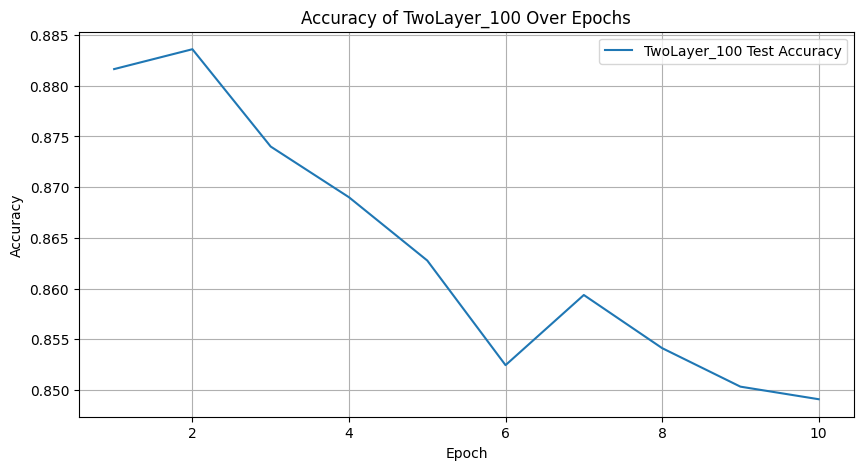

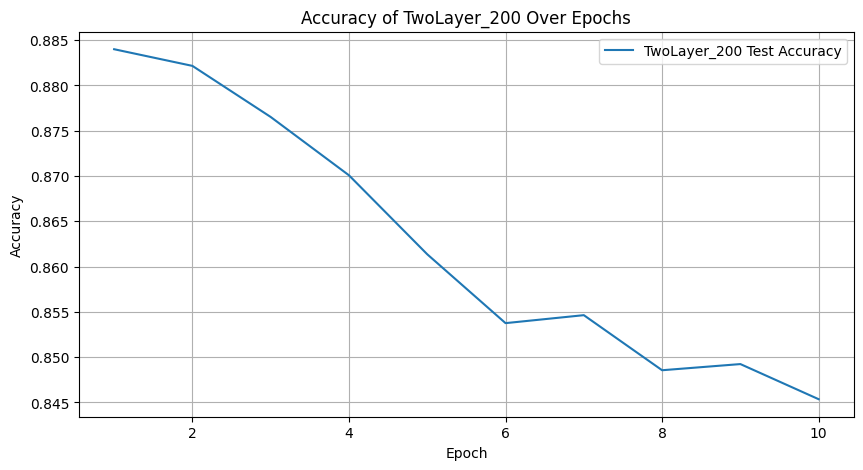

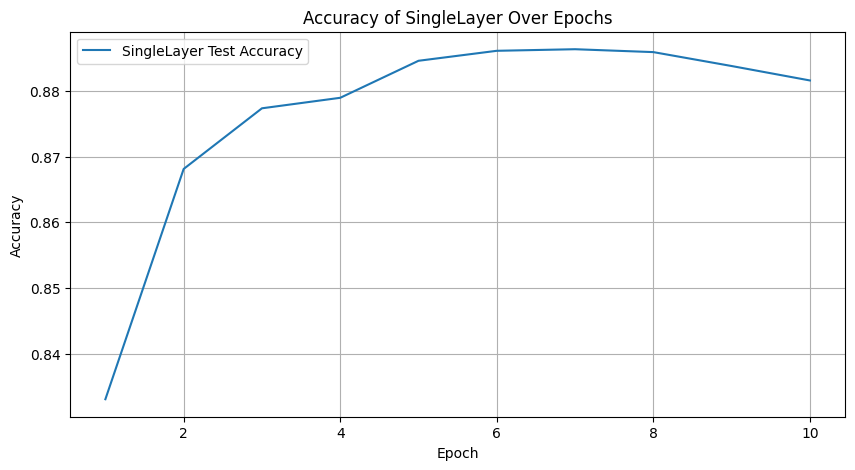

In [24]:
def plot_accuracy_single_model(model_name, test_accuracies, EPOCHS):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, EPOCHS+1), test_accuracies[model_name], label=f'{model_name} Test Accuracy')

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy of {model_name} Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function separately for each model
plot_accuracy_single_model('TwoLayer_100', test_accuracies, EPOCHS)
plot_accuracy_single_model('TwoLayer_200', test_accuracies, EPOCHS)
plot_accuracy_single_model('SingleLayer', test_accuracies, EPOCHS)

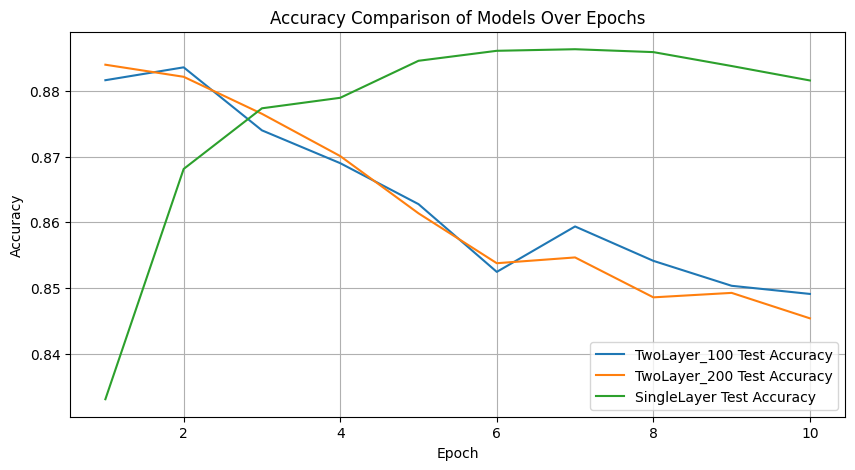

In [25]:
# Function to plot accuracy for all models over epochs
def plot_accuracy_all_models(test_accuracies, EPOCHS):
    plt.figure(figsize=(10, 5))

    # Plot the accuracies of all models
    for model_name, accuracies in test_accuracies.items():
        plt.plot(range(1, EPOCHS+1), accuracies, label=f'{model_name} Test Accuracy')

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Comparison of Models Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function to plot the accuracies of all models
plot_accuracy_all_models(test_accuracies, EPOCHS)

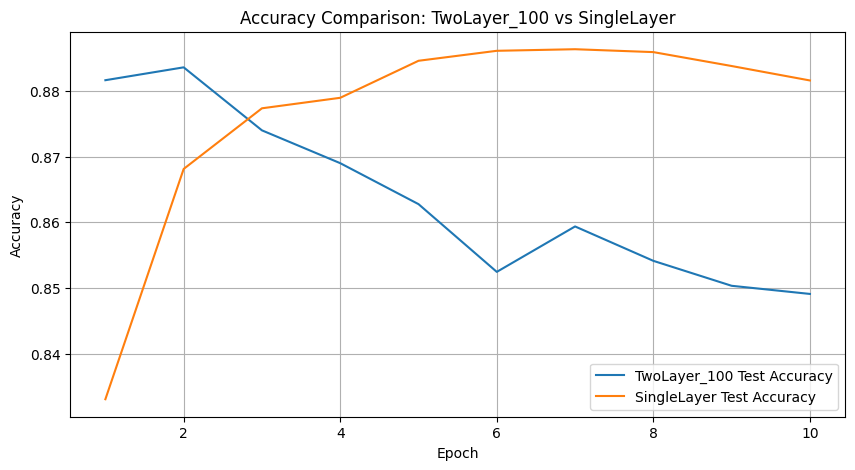

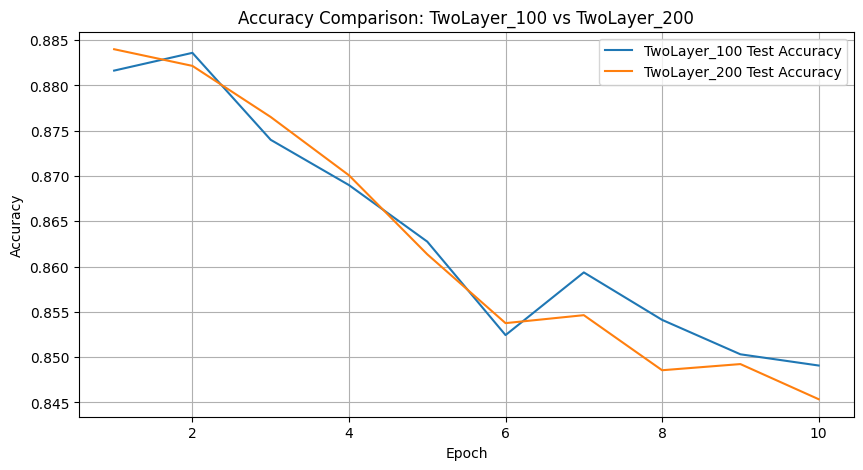

Performing Error Analysis for TwoLayer_100...
Sample 1:
Text: Blind Date (Columbia Pictures, 1934), was a decent film, but I have a few issues with this film. First of all, I don't fault the actors in this film at all, but more or less, I have a problem with the script. Also, I understand that this film was made in the 1930's and people were looking to escape reality, but the script made Ann Sothern's character look weak. She kept going back and forth between suitors and I felt as though she should have stayed with Paul Kelly's character in the end. He truly did care about her and her family and would have done anything for her and he did by giving her up in the end to fickle Neil Hamilton who in my opinion was only out for a good time. Paul Kelly's character, although a workaholic was a man of integrity and truly loved Kitty (Ann Sothern) as opposed to Neil Hamilton, while he did like her a lot, I didn't see the depth of love that he had for her character. The production values were g

In [26]:
# Plotting Accuracy Comparisons
# a. Compare TwoLayer_100 (Main) and SingleLayer
plot_accuracy_comparison('TwoLayer_100', 'SingleLayer', test_accuracies, EPOCHS)

# b. Compare TwoLayer_100 (Main) and TwoLayer_200
plot_accuracy_comparison('TwoLayer_100', 'TwoLayer_200', test_accuracies, EPOCHS)

# Detailed Evaluation for Main Model (TwoLayer_100) Only

print("Performing Error Analysis for TwoLayer_100...")
main_model = models['TwoLayer_100']
misclassified_samples = get_misclassified_samples(main_model, test_dataloader, sp)
display_misclassified_samples(misclassified_samples, num_samples=100)

## **Important Observations:**


### **Comparison between two-layer MLP and single layer MLP**

**Two-Layer MLP (100 Dimensions):**
```
Final Test Accuracy (Epoch 10): 84.87%
Peak Test Accuracy: ~88.48% at Epoch 2
```

*Single-Layer MLP:*

```
Final Test Accuracy (Epoch 10): 88.18%
Peak Test Accuracy: ~88.68% at Epoch 7
```



The Single-Layer MLP outperforms both Two-Layer MLPs. Reasons for Superior Performance of Single-Layer MLP:

Overfitting in Two-Layer Models:
Both two-layer models show a consistent decrease in test accuracy after a few epochs, indicating overfitting. They learn the training data too well, including its noise, which hampers generalization to unseen data.

Model Complexity: Two-Layer MLPs are inherently more complex than single-layer models. With increased depth and parameters, they are more prone to overfitting, especially if the dataset isn't sufficiently large or diverse.

### **Impact of Increasing Intermediate Layer Dimensions from 100 to 200**
**Two-Layer MLP (100 Dimensions):**
```
Final Test Accuracy (Epoch 10): 84.87%
```
**Two-Layer MLP (200 Dimensions):**
```
Final Test Accuracy (Epoch 10): 84.73%
```
The Two-Layer MLP with 100 Dimensions slightly outperforms the 200 Dimensions counterpart. Reasons can be diminshing returns that increasing the dimension doesn't really translate well to the performance. Overfitting is other problem. Doubling the intermediate layer dimensions increases the number of parameters, which can exacerbate overfitting, particularly evident in the decline of test accuracy for both models.

### **Error Analysis: Misclassifications in the Test Set**
All Misclassifications:

```
Actual Label: Negative | Predicted Label: Positive
Number of Samples Analyzed: 35
Nature of Texts: Predominantly negative movie reviews with critiques, dissatisfaction, and unfavorable opinions.
```
Reasons:
Class Imbalance: More Positive samples than negative; other reason can be Overfitting